In [10]:
%matplotlib widget
import sys
import os

from amftrack.util.sys import get_dirname, temp_path
import pandas as pd
import ast
from scipy import sparse
import scipy.io as sio
import cv2
import imageio.v2 as imageio
import numpy as np
import scipy.sparse
import os
from time import time
from amftrack.pipeline.functions.image_processing.extract_skel import (
    extract_skel_new_prince,
    run_back_sub,
    bowler_hat,
)

from amftrack.util.sys import get_dates_datetime, get_dirname
import shutil
from amftrack.pipeline.launching.run_super import (
    run_launcher,
    directory_scratch,
    directory_project,
    directory_project,
    run_parallel_stitch,
    run_parallel_transfer,
)
import os
from amftrack.util.sys import (
    get_dates_datetime,
    get_dirname,
    temp_path,
    get_data_info,
    update_plate_info,
    update_analysis_info,
    get_analysis_info,
    get_current_folders,
    get_folders_by_plate_id,
)
from time import time_ns
from amftrack.util.dbx import upload_folders, load_dbx, download, get_dropbox_folders
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
directory_targ = directory_project
update_plate_info(directory_targ, local=True)
all_folders = get_current_folders(directory_targ, local=True)
directory = directory_targ

analysed:   0%|          | 0/580 [00:00<?, ?it/s]

In [3]:
plates = ['078_20220920', '079_20220920', '080_20220920', '081_20220920',
       '082_20220920', '083_20220920', '084_20220920', '001_20220920',
       '024_20220920', '073_20220920', '002_20220920', '003_20220920',
       '004_20220920', '005_20220920', '006_20220920', '007_20220920',
       '008_20220920', '009_20220920', '010_20220920', '011_20220920',
       '012_20220920', '019_20220920', '020_20220920', '021_20220920',
       '022_20220920', '023_20220920', '037_20220920', '038_20220920',
       '039_20220920', '040_20220920', '042_20220920', '043_20220920',
       '044_20220920', '045_20220920', '046_20220920', '016_20220921',
       '017_20220921', '034_20220921', '051_20220920', '094_20220921',
       '064_20220921', '026_20220921', '027_20220921', '028_20220921',
       '029_20220921', '031_20220921', '033_20220921', '035_20220921',
       '036_20220921', '047_20220920', '041_20220920', '015_20220921',
       '068_20220921', '107_20220921', '095_20220921', '062_20220921',
       '096_20220921', '104_20220921', '050_20220920', '030_20220921',
       '025_20220921', '100_20220921', '067_20220921', '048_20220920',
       '055_20220921', '056_20220921', '057_20220921', '058_20220921',
       '059_20220921', '060_20220921', '061_20220921', '063_20220921',
       '014_20220921', '018_20220921', '099_20220921', '069_20220921',
       '054_20220920', '075_20220920', '092_20220921', '093_20220921',
       '097_20220921', '098_20220921', '105_20220921', '106_20220921',
       '108_20220921', '085_20220921', '086_20220921', '087_20220921',
       '088_20220921', '089_20220921', '090_20220921', '091_20220921',
       '049_20220920', '052_20220920', '053_20220920', '074_20220920',
       '076_20220920', '077_20220920', '013_20220921', '070_20220921',
       '071_20220921', '072_20220921', '102_20220921', '032_20220921',
       '101_20220921', '065_20220921', '066_20220921', '103_20220921']
plates = ['_'.join((str(int(plate.split('_')[0])),str(int(plate.split('_')[1])))) for plate in plates]

In [4]:
folders = all_folders.loc[all_folders["unique_id"].isin(plates)]
len(folders)

555

In [5]:
folders = folders.loc[folders['folder'] == "20220921_1624_Plate01"]

In [20]:
import sys
from amftrack.util.sys import get_dirname, pastis_path, fiji_path, path_code, temp_path
import pandas as pd
import shutil
from scipy import sparse
from datetime import datetime
from amftrack.pipeline.functions.image_processing.experiment_class_surf import orient
import scipy.io as sio
import cv2 as cv
import imageio.v2 as imageio
import numpy as np
from skimage.filters import frangi
from skimage import filters
import scipy.sparse
import os
from time import time
from skimage.feature import hessian_matrix_det
from amftrack.pipeline.functions.image_processing.extract_graph import (
    from_sparse_to_graph,
    generate_nx_graph,
)
from bresenham import bresenham
from time import time_ns
import subprocess


def streline(linelen, degrees):
    theta = degrees % 180 * np.pi / 180
    ray = (linelen - 1) / 2
    x = int(np.round((linelen - 1) / 2 * np.cos(theta)))
    y = -int(np.round((linelen - 1) / 2 * np.sin(theta)))
    points = np.array(list(bresenham(0, 0, x, y)))
    c, r = np.concatenate((-np.flip(points[:, 0]), [0], points[:, 0])), np.concatenate(
        (-np.flip(points[:, 1]), [0], points[:, 1])
    )
    M = 2 * np.max(np.abs(r)) + 1
    N = 2 * np.max(np.abs(c)) + 1
    line = np.zeros((M, N))
    x0 = np.expand_dims((r + np.max(np.abs(r))), 1)
    y0 = np.expand_dims((c + np.max(np.abs(c))), 1)
    line[x0, y0] = 1
    return line


def stredisk(radius):
    return cv.getStructuringElement(cv.MORPH_ELLIPSE, (2 * radius - 1, 2 * radius - 1))


def remove_component(dilated, min_size=4000):
    nb_components, output, stats, centroids = cv.connectedComponentsWithStats(
        dilated.astype(np.uint8), connectivity=8
    )
    # connectedComponentswithStats yields every seperated component with information on each of them, such as size
    # the following part is just taking out the background which is also considered a component, but most of the time we don't want that.
    sizes = stats[1:, -1]
    nb_components = nb_components - 1

    # minimum size of particles we want to keep (number of pixels)
    # here, it's a fixed value, but you can set it as you want, eg the mean of the sizes or whatever

    # your answer image
    img_f = np.zeros((dilated.shape))
    # for every component in the image, you keep it only if it's above min_size
    for i in range(0, nb_components):
        if sizes[i] >= min_size:
            img_f[output == i + 1] = 1
    return np.array(255 * img_f, dtype=np.uint8)


def bowler_hat(im, no, si):
    o = np.linspace(0, 180, no)
    imol = np.zeros((im.shape[0], im.shape[1], len(si), no))
    imod = np.zeros((im.shape[0], im.shape[1], len(si)))
    for i in range(0, len(si)):
        for j in range(0, no):
            se = streline(si[i], o[j]).astype(np.uint8)
            imol[:, :, i, j] = cv.morphologyEx(im, cv.MORPH_OPEN, se)
        se = stredisk(int(np.round(si[i] / 2))).astype(np.uint8)
        imod[:, :, i] = cv.morphologyEx(im, cv.MORPH_OPEN, se)
    imd = np.zeros((im.shape[0], im.shape[1], len(si)))
    imr = np.zeros((im.shape[0], im.shape[1], len(si)))
    imm = np.zeros((im.shape[0], im.shape[1], len(si)))
    triv = imod == 0
    for i in range(len(si)):
        imm[:, :, i] = np.max(np.squeeze(imol[:, :, i, :]), axis=2)
        imd[:, :, i] = imm[:, :, i] - imod[:, :, i]
    imr[triv] = 0
    imda = np.max(imd, axis=2)
    imda = np.double(imda)
    imda = (imda - np.min(imda[:])) / (np.max(imda[:]) - np.min(imda[:]))
    return imda


def extract_skel_new_prince(im, params, perc_low, perc_high):
    bowled = bowler_hat(-im.astype(np.uint8), 32, params)
    filename = time_ns()
    place_save = temp_path
    to_smooth = np.minimum(bowled * 255,255-im)
    # to_smooth = 255-im
    imtransformed_path = f"{place_save}/{filename}.tif"
    imageio.imsave(imtransformed_path, to_smooth.astype(np.uint8))
    path_anis = pastis_path
    args = [0.1, 7, 0.9, 10, 50]
    command = [path_anis, imtransformed_path] + args
    command = [str(elem) for elem in command]
    print("anis filtering")
    process = subprocess.run(command, cwd=place_save, stdout=subprocess.DEVNULL)
    foldname = (
        f"{filename}_ani-K{int(args[0]*10)}s{args[1]}g{int(args[2]*10)}itD{args[3]}"
    )
    imname = foldname + f"/{foldname}it{args[4]}.tif"
    path_modif = place_save + "/" + imname
    try:
        im2 = imageio.imread(path_modif)
    except:
        im2 = to_smooth.astype(np.uint8)
    print("image_reading")
    shutil.rmtree(os.path.join(place_save, foldname))
    low = max(20, np.percentile(im2, perc_low))
    high = max(90, np.percentile(im2, perc_high))
    transformed = im2
    hyst = filters.apply_hysteresis_threshold(transformed, low, high)
    dilated = remove_holes(hyst)
    dilated = dilated.astype(np.uint8)
    connected = remove_component(dilated)
    # os.remove(imtransformed_path)
    return connected


def extend_tip(skeletonized, dilated, dist):
    img2 = np.zeros((dilated.shape))
    nx_g = generate_nx_graph(
        from_sparse_to_graph(scipy.sparse.dok_matrix(skeletonized))
    )
    g, pos = nx_g
    tips = [node for node in g.nodes if g.degree(node) == 1]
    dilated_bis = np.copy(img2)
    for tip in tips:
        branch = np.array(
            orient(g.get_edge_data(*list(g.edges(tip))[0])["pixel_list"], pos[tip])
        )
        orientation = branch[0] - branch[min(branch.shape[0] - 1, 20)]
        orientation = orientation / (np.linalg.norm(orientation))
        window = 20
        x, y = pos[tip][0], pos[tip][1]
        if (
            x - window >= 0
            and x + window < dilated.shape[0]
            and y - window >= 0
            and y + window < dilated.shape[1]
        ):
            shape_tip = dilated[x - window : x + window, y - window : y + window]
            #             dist = 20
            for i in range(dist):
                pixel = (pos[tip] + orientation * i).astype(int)
                xp, yp = pixel[0], pixel[1]
                if (
                    xp - window >= 0
                    and xp + window < dilated.shape[0]
                    and yp - window >= 0
                    and yp + window < dilated.shape[1]
                ):
                    dilated_bis[
                        xp - window : xp + window, yp - window : yp + window
                    ] += shape_tip
    kernel = np.ones((3, 3), np.uint8)
    dilation = cv.dilate(dilated_bis.astype(np.uint8) * 255, kernel, iterations=1)
    for i in range(3):
        dilation = cv.erode(dilation.astype(np.uint8) * 255, kernel, iterations=1)
        dilation = cv.dilate(dilation.astype(np.uint8) * 255, kernel, iterations=1)
    dilation = cv.erode(
        dilation.astype(np.uint8) * 255, kernel, iterations=2
    )  # recent addition for agg, careful
    return dilation > 0


def remove_holes(hyst):
    kernel = np.ones((3, 3), np.uint8)
    dilation = cv.dilate(hyst.astype(np.uint8) * 255, kernel, iterations=1)
    for i in range(3):
        dilation = cv.erode(dilation.astype(np.uint8) * 255, kernel, iterations=1)
        dilation = cv.dilate(dilation.astype(np.uint8) * 255, kernel, iterations=1)
    return dilation > 0


def extract_skel_tip_ext(im, low, high, dist):
    im_cropped = im
    im_blurred = cv.blur(im_cropped, (200, 200))
    im_back_rem = (
        (im_cropped)
        / ((im_blurred == 0) * np.ones(im_blurred.shape) + im_blurred)
        * 120
    )
    im_back_rem[im_back_rem >= 130] = 130
    frangised = frangi(im_back_rem, sigmas=range(1, 20, 4)) * 255
    transformed = (frangised - im_back_rem + 120) * (im_blurred >= 35)
    hyst = filters.apply_hysteresis_threshold(transformed, low, high)

    dilated = remove_holes(hyst)
    dilated = dilated.astype(np.uint8)
    connected = remove_component(dilated)
    skeletonized = cv.ximgproc.thinning(connected)
    dilation = extend_tip(skeletonized, dilated, dist)
    return dilation


def make_back_sub(directory, dirname, op_id):
    a_file = open(
        f"{path_code}pipeline/scripts/stitching_loops/background_substract.ijm", "r"
    )

    list_of_lines = a_file.readlines()

    list_of_lines[4] = f"mainDirectory = \u0022{directory}\u0022 ;\n"
    list_of_lines[29] = f"\t if(startsWith(list[i],\u0022{dirname}\u0022)) \u007b\n"
    file_name = f"{temp_path}/stitching_loops/background_substract{op_id}.ijm"
    a_file = open(file_name, "w")

    a_file.writelines(list_of_lines)

    a_file.close()


def run_back_sub(directory, folder):
    op_id = time_ns()
    make_back_sub(directory, folder, op_id)
    command = [
        fiji_path,
        "--mem=8000m",
        "--headless",
        "--ij2",
        "--console",
        "-macro",
        f'{os.getenv("TEMP")}/stitching_loops/background_substract{op_id}.ijm',
    ]
    subprocess.run(command, stdout=subprocess.DEVNULL)


Directory  /projects/0/einf914/data/20220921_1624_Plate01/Analysis  already exists
Img_r01_c01.tif
segmenting
anis filtering
image_reading


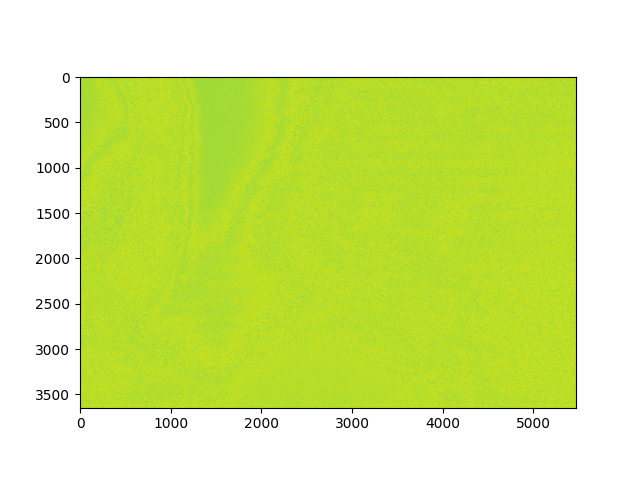

In [21]:
i= 0 
hyph_width = 30
perc_low = 93
perc_high = 99.5
run_info = folders
folder_list = list(run_info["folder"])
folder_list.sort()
directory_name = folder_list[i]
# run_back_sub(directory, directory_name)
path_snap = os.path.join(directory, directory_name)
path_tile = os.path.join(path_snap, "Img/TileConfiguration.txt.registered")
try:
    tileconfig = pd.read_table(
        path_tile,
        sep=";",
        skiprows=4,
        header=None,
        converters={2: ast.literal_eval},
        skipinitialspace=True,
    )
except:
    print("error_name")
    path_tile = os.path.join(path_snap, "Img/TileConfiguration.registered.txt")
    tileconfig = pd.read_table(
        path_tile,
        sep=";",
        skiprows=4,
        header=None,
        converters={2: ast.literal_eval},
        skipinitialspace=True,
    )
dirName = path_snap + "/Analysis"
try:
    os.mkdir(path_snap + "/Analysis")
    print("Directory ", dirName, " Created ")
except FileExistsError:
    print("Directory ", dirName, " already exists")
t = time()
xs = [c[0] for c in tileconfig[2]]
ys = [c[1] for c in tileconfig[2]]
name = tileconfig[0][0]
imname = "/Img3/" + name.split("/")[-1]
im = imageio.imread(directory + directory_name + imname)
dim = (
    int(np.max(ys) - np.min(ys)) + max(im.shape),
    int(np.max(xs) - np.min(xs)) + max(im.shape),
)
ims = []
params = [30]
list_debug = ['Img_r01_c01.tif']
# for index, name in enumerate(tileconfig[0]):
for index, name in enumerate(list_debug):
    print(name)
    imname = "/Img3/" + name.split("/")[-1]
    im = imageio.imread(directory + directory_name + imname)
    fig,ax = plt.subplots()
    ax.imshow(im)
    imname2 = "/Img/" + name.split("/")[-1]
    im2 = imageio.imread(directory + directory_name + imname2)
    bowled2 = bowler_hat(-im2, 32, params)
    im[bowled2 <= 0.09] = np.maximum(im[bowled2 <= 0.09], 250)
    shape = im.shape
    print("segmenting")
    segmented = extract_skel_new_prince(im, [hyph_width], perc_low, perc_high)

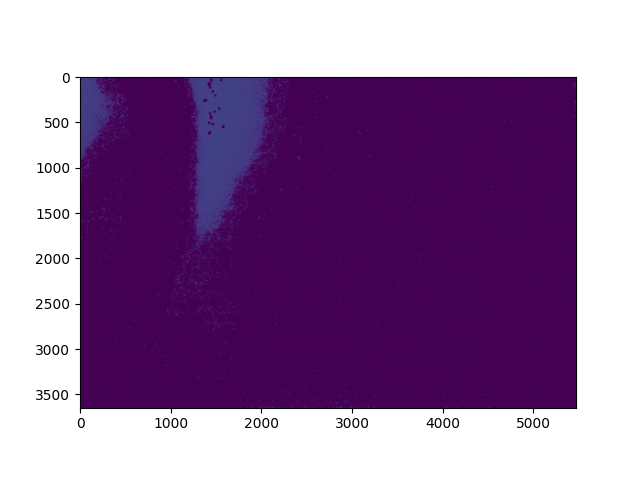

In [18]:
fig,ax = plt.subplots()
bowled = bowler_hat(-im.astype(np.uint8), 32, params)
filename = time_ns()
place_save = temp_path
to_smooth = np.minimum(bowled * 255,255-im)
ax.imshow(to_smooth)

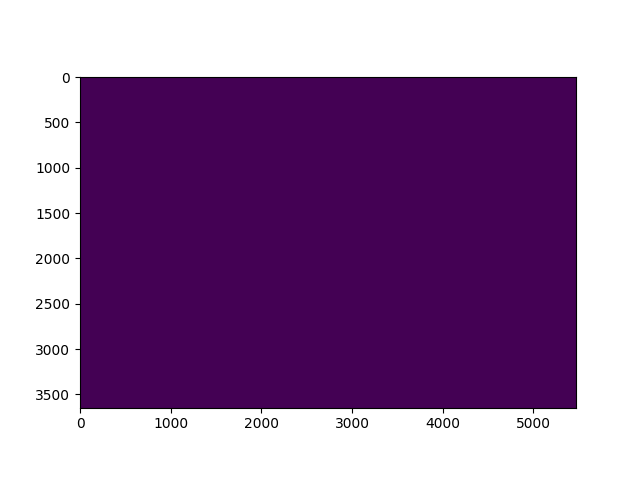

In [22]:
imname = "/Img3/" + name.split("/")[-1]
# im = imageio.imread(directory + directory_name + imname)
fig,ax = plt.subplots()
ax.imshow(segmented)

In [25]:
bowled = bowler_hat(-im.astype(np.uint8), 32, params)
filename = time_ns()
place_save = temp_path
to_smooth = bowled * 255
# to_smooth = 255-im
imtransformed_path = f"{place_save}/{filename}.tif"
imageio.imsave(imtransformed_path, to_smooth.astype(np.uint8))
path_anis = pastis_path
args = [0.1, 7, 0.9, 10, 50]
command = [path_anis, imtransformed_path] + args
command = [str(elem) for elem in command]
print("anis filtering")
process = subprocess.run(command, cwd=place_save, stdout=subprocess.DEVNULL)
foldname = (
    f"{filename}_ani-K{int(args[0]*10)}s{args[1]}g{int(args[2]*10)}itD{args[3]}"
)
imname = foldname + f"/{foldname}it{args[4]}.tif"
path_modif = place_save + "/" + imname
try:
    im2 = imageio.imread(path_modif)
except:
    im2 = to_smooth.astype(np.uint8)
print("image_reading")
shutil.rmtree(os.path.join(place_save, foldname))
low = max(20, np.percentile(im2, perc_low))
high = max(90, np.percentile(im2, perc_high))
transformed = im2
hyst = filters.apply_hysteresis_threshold(transformed, low, high)
dilated = remove_holes(hyst)
dilated = dilated.astype(np.uint8)
connected = remove_component(dilated)

anis filtering
image_reading


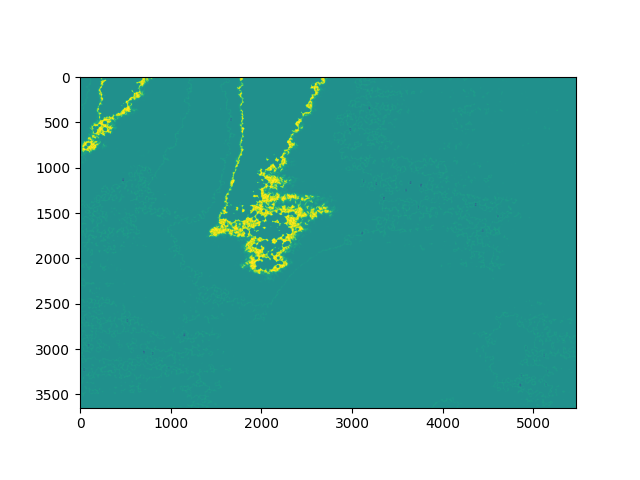

In [26]:
fig,ax = plt.subplots()
ax.imshow(bowled)

In [1]:
import os
import sys


# sys.path.insert(0,r'C:\Users\coren\Documents\PhD\Code\AMFtrack')

import pandas as pd
from amftrack.util.sys import (
    update_plate_info,
    get_current_folders,
)

from datetime import datetime, timedelta
from amftrack.util.dbx import upload_folders
from time import time_ns

directory_origin = r"/mnt/sun-temp/TEMP/PRINCE_syncing/"
dir_drop = "DATA/PRINCE"
suffix_data_info = str(time_ns())
update_plate_info(
    directory_origin,
    local=True,
    strong_constraint=False,
    suffix_data_info=suffix_data_info,
)
all_folders_origin = get_current_folders(directory_origin, local=True)

all_folders_origin["date_datetime"] = pd.to_datetime(
    all_folders_origin["date"].astype(str), format="%d.%m.%Y, %H:%M:"
)
selection = (datetime.now() - all_folders_origin["date_datetime"]) <= timedelta(days=3)
current_prince = all_folders_origin.loc[selection]
plates_in_prince = current_prince["unique_id"].unique()
old_folders = all_folders_origin.loc[
    all_folders_origin["unique_id"].isin(plates_in_prince) == False
]

old_folders["Plate"] = (
    old_folders["Plate"].str.replace("R", "66666").str.replace("[^0-9]", "")
)
old_folders = old_folders.sort_values(by=["datetime"], ignore_index=True)

/home/ipausers/bisot/pycode/MscThesis/amftrack/util/dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


analysed:   0%|          | 0/8132 [00:00<?, ?it/s]

/home/ipausers/bisot/temp/ipykernel_1919382/3022742164.py:31: FutureWarning: The default value of regex will change from True to False in a future version.
  old_folders["Plate"].str.replace("R", "66666").str.replace("[^0-9]", "")
/home/ipausers/bisot/temp/ipykernel_1919382/3022742164.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  old_folders["Plate"] = (


In [4]:
old_folders["folder"]

0       20220506_2344_Plate01
1       20220506_2347_Plate02
2       20220506_2350_Plate03
3       20220507_0144_Plate01
4       20220507_0147_Plate02
                ...          
3362    20220620_0524_Plate33
3363    20220621_0916_Plate25
3364    20220621_0928_Plate30
3365    20220621_0931_Plate31
3366    20220621_0934_Plate33
Name: folder, Length: 3367, dtype: object

In [2]:
from parameters import a


def plus(x, y=a):
    return x + y


plus(1)

3

In [124]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
import os
import sys

sys.path.insert(0, r"/home/ipausers/bisot/pycode/MscThesis")
# sys.path.insert(0,r'C:\Users\coren\Documents\PhD\Code\AMFtrack')

import pandas as pd
from amftrack.util.sys import (
    get_dates_datetime,
    get_dirname,
    temp_path,
    get_data_info,
    update_plate_info,
    get_current_folders,
    get_folders_by_plate_id,
)

import pandas as pd
import ast
from scipy import sparse
from datetime import datetime
from amftrack.pipeline.functions.image_processing.node_id import orient
import scipy.io as sio
import cv2
import imageio
import numpy as np
from skimage.filters import frangi
from skimage import filters
import scipy.sparse
import os
from time import time
from skimage.feature import hessian_matrix_det
from amftrack.pipeline.functions.image_processing.extract_graph import (
    from_sparse_to_graph,
    generate_nx_graph,
)
from amftrack.pipeline.functions.image_processing.extract_skel import (
    extract_skel_new_prince,
    run_back_sub,
)
import matplotlib.pyplot as plt
import cv2 as cv
from tqdm.autonotebook import tqdm
from time import time_ns
import subprocess
from decouple import Config, RepositoryEnv
import shutil

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [125]:
from amftrack.util.sys import get_dirname, temp_path, pastis_path, fiji_path, path_code
import pandas as pd
import ast
from scipy import sparse
from datetime import datetime
from amftrack.pipeline.functions.image_processing.node_id import orient
import scipy.io as sio
import cv2 as cv
import imageio
import numpy as np
from skimage.filters import frangi
from skimage import filters
import scipy.sparse
import os
from time import time
from skimage.feature import hessian_matrix_det
from amftrack.pipeline.functions.image_processing.extract_skel import bowler_hat
from bresenham import bresenham
from time import time_ns
import subprocess
from amftrack.pipeline.functions.image_processing.extract_skel import (
    extract_skel_new_prince,
    run_back_sub,
)

In [4]:
directory = "/mnt/sun/home-folder/bisot/PRINCE_test/"
update_plate_info(directory, local=True)

all_folders = get_current_folders(directory, local=True)

analysed:   0%|          | 0/22 [00:00<?, ?it/s]

In [126]:
all_folders

,total_path,Plate,PrincePos,root,strain,medium,split,Pbait,CrossDate,Temperature,...,/Analysis/transform.mat,/Analysis/transform_corrupt.mat,/Analysis/skeleton_realigned_compressed.mat,/Analysis/nx_graph_pruned.p,/Analysis/nx_graph_pruned_width.p,/Analysis/nx_graph_pruned_labeled.p,date,folder,unique_id,datetime
0,/mnt/sun/home-folder/bisot/PRINCE_test/2022070...,52,7,'Carrot','A5','001P100N100C','Y','-',20220707,25,...,True,False,True,True,True,True,"07.07.2022, 23:15:",20220707_2315_Plate07,52_20220707,2022-07-07 23:15:00
1,/mnt/sun/home-folder/bisot/PRINCE_test/2022070...,52,7,'Carrot','A5','001P100N100C','Y','-',20220707,25,...,True,False,True,True,True,True,"08.07.2022, 03:15:",20220708_0315_Plate07,52_20220707,2022-07-08 03:15:00
2,/mnt/sun/home-folder/bisot/PRINCE_test/2022070...,52,7,'Carrot','A5','001P100N100C','Y','-',20220707,25,...,True,False,True,True,True,True,"08.07.2022, 19:50:",20220708_1950_Plate07,52_20220707,2022-07-08 19:50:00
3,/mnt/sun/home-folder/bisot/PRINCE_test/2022070...,52,7,'Carrot','A5','001P100N100C','Y','-',20220707,25,...,True,False,True,True,True,True,"07.07.2022, 21:15:",20220707_2115_Plate07,52_20220707,2022-07-07 21:15:00
4,/mnt/sun/home-folder/bisot/PRINCE_test/2022070...,52,7,'Carrot','A5','001P100N100C','Y','-',20220707,25,...,True,False,True,True,True,True,"08.07.2022, 01:15:",20220708_0115_Plate07,52_20220707,2022-07-08 01:15:00
5,/mnt/sun/home-folder/bisot/PRINCE_test/2022070...,52,7,'Carrot','A5','001P100N100C','Y','-',20220707,25,...,True,False,True,True,True,True,"08.07.2022, 07:15:",20220708_0715_Plate07,52_20220707,2022-07-08 07:15:00
6,/mnt/sun/home-folder/bisot/PRINCE_test/2022070...,52,7,'Carrot','A5','001P100N100C','Y','-',20220707,25,...,False,False,True,True,True,True,"07.07.2022, 14:58:",20220707_1458_Plate07,52_20220707,2022-07-07 14:58:00
7,/mnt/sun/home-folder/bisot/PRINCE_test/2022070...,52,7,'Carrot','A5','001P100N100C','Y','-',20220707,25,...,True,False,True,True,True,True,"08.07.2022, 05:15:",20220708_0515_Plate07,52_20220707,2022-07-08 05:15:00
8,/mnt/sun/home-folder/bisot/PRINCE_test/2022070...,52,7,'Carrot','A5','001P100N100C','Y','-',20220707,25,...,True,False,True,True,True,True,"08.07.2022, 13:50:",20220708_1350_Plate07,52_20220707,2022-07-08 13:50:00
9,/mnt/sun/home-folder/bisot/PRINCE_test/2022070...,52,7,'Carrot','A5','001P100N100C','Y','-',20220707,25,...,True,False,True,True,True,True,"08.07.2022, 09:15:",20220708_0915_Plate07,52_20220707,2022-07-08 09:15:00


In [128]:
directory_name = "20220708_2350_Plate07"
folders = all_folders.loc[all_folders["folder"] == directory_name]
folders

,total_path,Plate,PrincePos,root,strain,medium,split,Pbait,CrossDate,Temperature,...,/Analysis/transform.mat,/Analysis/transform_corrupt.mat,/Analysis/skeleton_realigned_compressed.mat,/Analysis/nx_graph_pruned.p,/Analysis/nx_graph_pruned_width.p,/Analysis/nx_graph_pruned_labeled.p,date,folder,unique_id,datetime
19,/mnt/sun/home-folder/bisot/PRINCE_test/2022070...,52,7,'Carrot','A5','001P100N100C','Y','-',20220707,25,...,True,False,True,True,True,True,"08.07.2022, 23:50:",20220708_2350_Plate07,52_20220707,2022-07-08 23:50:00


In [131]:
run_back_sub(directory, directory_name)

Java HotSpot(TM) 64-Bit Server VM warning: ignoring option PermSize=128m; support was removed in 8.0
Java HotSpot(TM) 64-Bit Server VM warning: Using incremental CMS is deprecated and will likely be removed in a future release


/data/temp/ipykernel_1288575/1607774635.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im4 = imageio.imread(path_im)


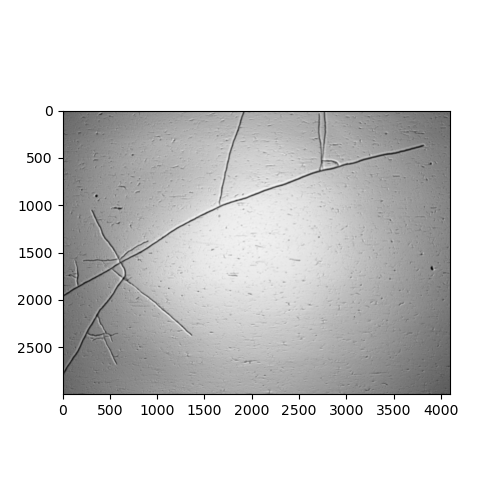

In [129]:
i = 0
run_info = folders
folder_list = list(run_info["folder"])
folder_list.sort()
directory_name = folder_list[i]
imname = "/Img/Img_r08_c09.tif"
path_im = directory + directory_name + imname
im4 = imageio.imread(path_im)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
# im[im>=190]=140
ax.imshow(im4, cmap="gray")

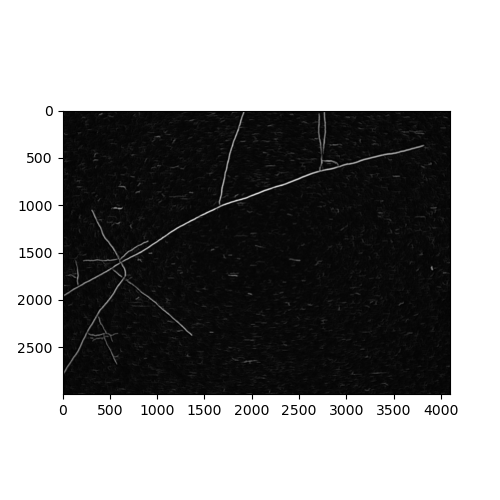

In [91]:
bowled2 = bowler_hat(-im4, 32, params)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
# im[im>=190]=140
ax.imshow(bowled2, cmap="gray")

In [130]:
i = 0
run_info = folders
folder_list = list(run_info["folder"])
folder_list.sort()
directory_name = folder_list[i]
imname = "/Img3/Img_r08_c09.tif"
path_im = directory + directory_name + imname
im = imageio.imread(path_im)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
# ax.imshow(im, cmap="Blues")
ax.imshow(-im, cmap="gray")
# im[bowled2<=0.09]=254
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
# ax.imshow(im, cmap="Blues")
ax.imshow(-im, cmap="gray")

/data/temp/ipykernel_1288575/1119883131.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread(path_im)


FileNotFoundError: No such file: '/mnt/sun/home-folder/bisot/PRINCE_test/20220708_2350_Plate07/Img3/Img_r08_c09.tif'

In [119]:
params = [30]
perc_low = 93
perc_high = 99.5
bowled = bowler_hat(-im, 32, params)
filename = time_ns()
place_save = temp_path
to_smooth = bowled * 255
# to_smooth = 255-im
imtransformed_path = f"{place_save}/{filename}.tif"
imageio.imsave(imtransformed_path, to_smooth.astype(np.uint8))
path_anis = pastis_path
args = [0.1, 7, 0.9, 10, 50]
command = [path_anis, imtransformed_path] + args
command = [str(elem) for elem in command]
process = subprocess.run(command, cwd=place_save, stdout=subprocess.DEVNULL)
foldname = f"{filename}_ani-K{int(args[0]*10)}s{args[1]}g{int(args[2]*10)}itD{args[3]}"
imname = foldname + f"/{foldname}it{args[4]}.tif"
path_modif = place_save + "/" + imname
im2 = imageio.imread(path_modif)
low = max(20, np.percentile(im2, perc_low))
high = max(90, np.percentile(im2, perc_high))
# transformed = -img+255
transformed = im2
hyst = filters.apply_hysteresis_threshold(transformed, low, high)

/data/temp/ipykernel_1288575/3079736234.py:19: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im2 = imageio.imread(path_modif)


In [120]:
low

20

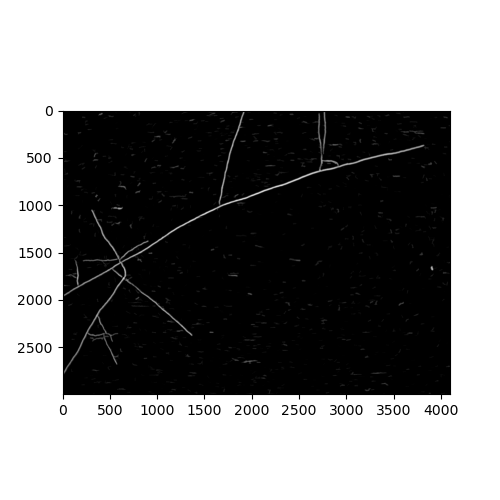

In [121]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ax.imshow(bowled, cmap="gray")

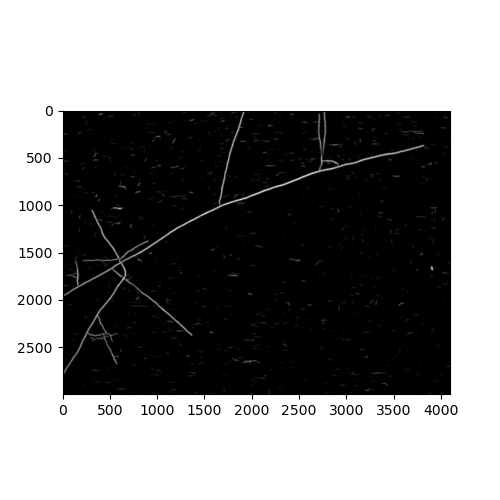

In [122]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ax.imshow(im2, cmap="gray")

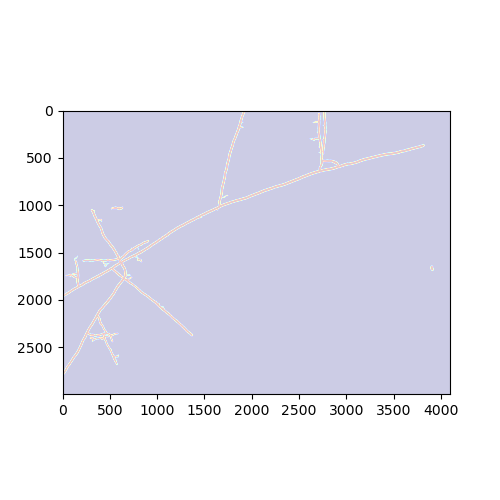

In [123]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
# ax.imshow(im,cmap='gray')
ax.imshow(hyst, cmap="jet", alpha=0.2)

In [22]:
%autoreload 2
params = [30]
perc_low = 93
perc_high = 99.5
connected = extract_skel_new_prince(im, params, perc_low, perc_high)

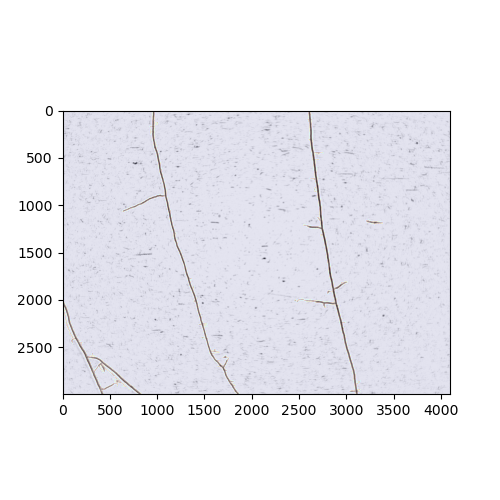

In [23]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ax.imshow(im, cmap="gray")
ax.imshow(connected, cmap="jet", alpha=0.1)

In [24]:
low = np.percentile(connected, perc_low)
high = max(70, np.percentile(connected, perc_high))
low, high

(3.0, 70)

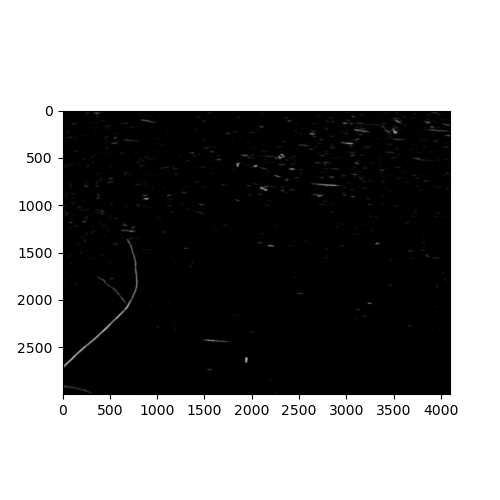

In [18]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ax.imshow(connected, cmap="gray")

In [26]:
hyst = filters.apply_hysteresis_threshold(connected, low, high)

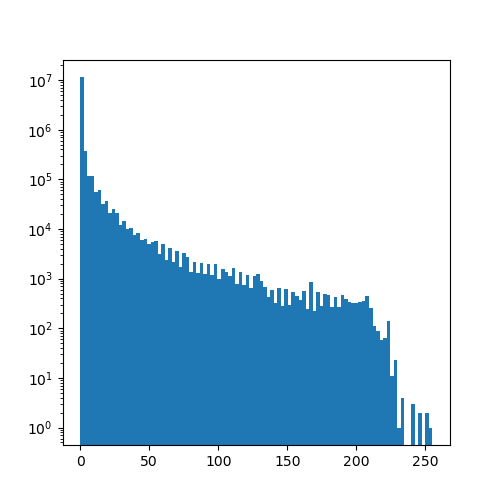

In [23]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ax.hist(np.ndarray.flatten(connected), 100)
ax.set_yscale("log")

In [28]:
xs = [c[0] for c in tileconfig[2]]
ys = [c[1] for c in tileconfig[2]]
dim = (int(np.max(ys) - np.min(ys)) + 4096, int(np.max(xs) - np.min(xs)) + 4096)

In [29]:
home / ipausers / bisot / miniconda3 / envs / amftrack / bin / pyt()

(27081, 52139)

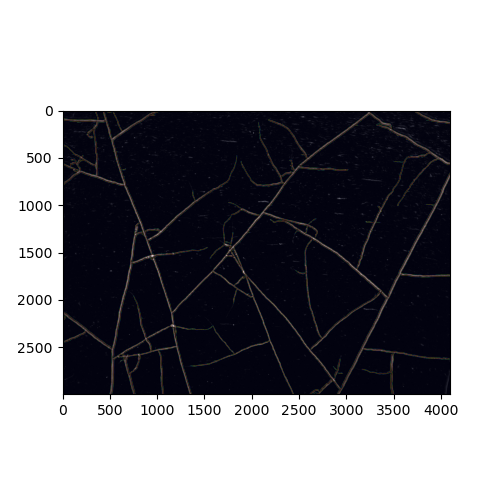

In [17]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ax.imshow(-im, cmap="gray")
ax.imshow(connected, alpha=0.1, cmap="jet")

In [21]:
folder_list = list(run_info["folder"])
folder_list.sort()
directory_name = folder_list[i]
im_fold = "/Img2"
to_delete = directory + directory_name + im_fold
shutil.rmtree(to_delete)

In [58]:
kernel = np.ones((3, 3), np.uint8)
dilation = cv.dilate(hyst.astype(np.uint8) * 255, kernel, iterations=1)
for i in range(3):
    dilation = cv.erode(dilation.astype(np.uint8) * 255, kernel, iterations=1)
    dilation = cv.dilate(dilation.astype(np.uint8) * 255, kernel, iterations=1)
dilated = dilation > 0
nb_components, output, stats, centroids = cv.connectedComponentsWithStats(
    dilated.astype(np.uint8), connectivity=8
)
# connectedComponentswithStats yields every seperated component with information on each of them, such as size
# the following part is just taking out the background which is also considered a component, but most of the time we don't want that.
sizes = stats[1:, -1]
nb_components = nb_components - 1

# minimum size of particles we want to keep (number of pixels)
# here, it's a fixed value, but you can set it as you want, eg the mean of the sizes or whatever
min_size = 4000

# your answer image
img_f = np.zeros((dilated.shape))
# for every component in the image, you keep it only if it's above min_size
for i in range(0, nb_components):
    if sizes[i] >= min_size:
        img_f[output == i + 1] = 1
skeletonized = cv.ximgproc.thinning(np.array(255 * img_f, dtype=np.uint8))